In [688]:
import pandas as pd
import numpy as np
from datetime import datetime

import matplotlib
matplotlib.use('Agg')
%matplotlib inline

import matplotlib.pyplot as plt

import torch
import torch.nn as nn 
from torch.autograd import Variable
import torch.optim as optim

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

In [689]:
## import data
df = pd.read_excel("/附件1：物流网络历史货量数据.xlsx")
df

,场地1,场地2,日期,货量
0,DC3,DC5,2021-01-01,3
1,DC3,DC10,2021-01-01,4
2,DC3,DC14,2021-01-01,4
3,DC5,DC3,2021-01-01,41
4,DC5,DC9,2021-01-01,3
...,...,...,...,...
177842,DC73,DC5,2022-12-31,2479
177843,DC73,DC8,2022-12-31,150
177844,DC73,DC10,2022-12-31,8116
177845,DC73,DC14,2022-12-31,6139


In [690]:
df

,场地1,场地2,日期,货量
0,DC3,DC5,2021-01-01,3
1,DC3,DC10,2021-01-01,4
2,DC3,DC14,2021-01-01,4
3,DC5,DC3,2021-01-01,41
4,DC5,DC9,2021-01-01,3
...,...,...,...,...
177842,DC73,DC5,2022-12-31,2479
177843,DC73,DC8,2022-12-31,150
177844,DC73,DC10,2022-12-31,8116
177845,DC73,DC14,2022-12-31,6139


In [691]:
# Rename column names
df.rename(columns={"场地1":"one", "场地2":"two", "日期":"date", "货量":"value"}, inplace=True)
print(df.columns)

Index(['one', 'two', 'date', 'value'], dtype='object')


In [692]:
from numpy.ma.extras import unique
#to required origin
DC14 = df[df['two'] == "DC14"]
dic_14 = {}
for i in unique(DC14['one']):
  dic_14[i] = len(DC14[DC14['one'] == i])

DC20 = df[df['two'] == "DC20"]
dic_20 = {}
for i in unique(DC20['one']):
  dic_20[i] = len(DC20[DC20['one'] == i])

DC25 = df[df['two'] == "DC25"]
dic_25 = {}
for i in unique(DC25['one']):
  dic_25[i] = len(DC25[DC25['one'] == i])

In [693]:
sorted14 = sorted(dic_14.items(), key=lambda item: item[1], reverse=True)
sorted20 = sorted(dic_20.items(), key=lambda item: item[1], reverse=True)
sorted25 = sorted(dic_25.items(), key=lambda item: item[1], reverse=True)
print(sorted14[:10])
print(sorted20[:10])
print(sorted25[:10])

[('DC10', 730), ('DC15', 730), ('DC19', 730), ('DC20', 730), ('DC22', 730), ('DC25', 730), ('DC28', 730), ('DC30', 730), ('DC36', 730), ('DC42', 730)]
[('DC4', 9), ('DC10', 8), ('DC62', 8), ('DC55', 6), ('DC14', 5), ('DC19', 2), ('DC21', 2), ('DC17', 1), ('DC22', 1), ('DC23', 1)]
[('DC53', 39), ('DC9', 4), ('DC10', 3), ('DC14', 3), ('DC8', 1)]


In [694]:
#to required destination (required destination需求量)
to10 = df[df['two'] == "DC10"]
dic_to_10 = {i : len(to10[to10['one'] == i]) for i in unique(to10['one'])}

to35 = df[df['two'] == "DC35"]
dic_to_35 = {i : len(to35[to35['one'] == i]) for i in unique(to35['one'])}

to62 = df[df['two'] == "DC62"]
dic_to_62 = {i : len(to62[to62['one'] == i]) for i in unique(to62['one'])}

sorted_to_10 = sorted(dic_to_10.items(), key=lambda item: item[1], reverse=True)
sorted_to_35 = sorted(dic_to_35.items(), key=lambda item: item[1], reverse=True)
sorted_to_62 = sorted(dic_to_62.items(), key=lambda item: item[1], reverse=True)

print(sorted_to_10)
print(sorted_to_35)
print(sorted_to_62)

[('DC14', 726), ('DC20', 724), ('DC23', 724), ('DC36', 724), ('DC19', 722), ('DC17', 721), ('DC25', 721), ('DC22', 720), ('DC30', 720), ('DC28', 718), ('DC15', 717), ('DC44', 717), ('DC51', 716), ('DC55', 716), ('DC38', 715), ('DC31', 713), ('DC73', 711), ('DC47', 710), ('DC26', 706), ('DC46', 705), ('DC48', 688), ('DC7', 684), ('DC71', 679), ('DC43', 660), ('DC42', 659), ('DC50', 658), ('DC21', 573), ('DC8', 520), ('DC52', 499), ('DC4', 497), ('DC34', 478), ('DC40', 440), ('DC62', 319), ('DC5', 315), ('DC37', 303), ('DC58', 239), ('DC68', 212), ('DC9', 209), ('DC57', 208), ('DC3', 205), ('DC66', 200), ('DC27', 190), ('DC45', 183), ('DC72', 148), ('DC56', 139), ('DC70', 125), ('DC41', 91), ('DC59', 76), ('DC35', 74), ('DC53', 72), ('DC60', 72), ('DC13', 55), ('DC49', 48), ('DC74', 43), ('DC33', 28), ('DC11', 26), ('DC39', 19), ('DC16', 16), ('DC12', 11), ('DC24', 11), ('DC64', 10), ('DC65', 9), ('DC2', 7), ('DC67', 7), ('DC18', 6), ('DC61', 5), ('DC76', 5), ('DC63', 4), ('DC69', 4), ('

In [695]:
#Required route
DC14_DC10 = df[(df["one"] == "DC14") & (df["two"] == "DC10")]
DC20_DC35 = df[(df["one"] == "DC20") & (df["two"] == "DC35")]
DC25_DC62 = df[(df["one"] == "DC25") & (df["two"] == "DC62")]
DC14_DC10 = DC14_DC10[["date", "value"]]
DC20_DC35 = DC20_DC35[["date", "value"]]
DC25_DC62 = DC25_DC62[["date", "value"]]

In [696]:
#Dependent route
#to required origin
#DC14->DC10
DC15_DC14 = df[(df["one"] == "DC15") & (df["two"] == "DC14")]
DC22_DC14 = df[(df["one"] == "DC22") & (df["two"] == "DC14")]
DC42_DC14 = df[(df["one"] == "DC42") & (df["two"] == "DC14")]

DC15_DC14 = DC15_DC14[["date", "value"]]
DC22_DC14 = DC22_DC14[["date", "value"]]
DC42_DC14 = DC42_DC14[["date", "value"]]
#DC20->DC35
DC4_DC20 = df[(df["one"] == "DC4") & (df["two"] == "DC20")]
#DC25->DC62
DC53_DC25 = df[(df["one"] == "DC53") & (df["two"] == "DC25")]

#to required destination (required destination需求量)
#DC14->DC10
DC20_DC10 = df[(df["one"] == "DC20") & (df["two"] == "DC10")]
DC23_DC10 = df[(df["one"] == "DC23") & (df["two"] == "DC10")]
DC36_DC10 = df[(df["one"] == "DC36") & (df["two"] == "DC10")]

DC20_DC10 = DC20_DC10[["date", "value"]]
DC23_DC10 = DC23_DC10[["date", "value"]]
DC36_DC10 = DC36_DC10[["date", "value"]]
#DC20->DC35
DC10_DC35 = df[(df["one"] == "DC10") & (df["two"] == "DC35")]
#DC25->DC62
DC8_DC62 = df[(df["one"] == "DC8") & (df["two"] == "DC62")]

In [697]:
date_range = pd.date_range("2021-1-1", "2022-12-31")
all_dates_df = pd.DataFrame({'date': date_range})
DC14_DC10 = pd.merge(all_dates_df, DC14_DC10, on='date', how='left')
DC14_DC10['value'].fillna(0, inplace=True)
DC20_DC35 = pd.merge(all_dates_df, DC20_DC35, on='date', how='left')
DC20_DC35['value'].fillna(0, inplace=True)
DC25_DC62 = pd.merge(all_dates_df, DC25_DC62, on='date', how='left')
DC25_DC62['value'].fillna(0, inplace=True)
print(len(DC14_DC10))
print(len(DC20_DC35))
print(len(DC25_DC62))

730
730
730


In [698]:
# #route1: DC14->DC10
# route1 = pd.merge(DC14_DC10, DC15_DC14, on='date', how='left')
# route1 = pd.merge(route1, DC20_DC10, on='date', how='left')
# route1 = route1[['date', 'value_x', 'value_y', 'value']]
# route1.rename(columns={"date":"date", "value_x":"value", "value_y":"toDC14", "value":"toDC10"}, inplace=True)
# route1['toDC14'].fillna(0, inplace = True)
# route1['toDC10'].fillna(0, inplace = True)

# route1.set_index('date', inplace=True)
# route1

In [699]:
# DC10_DC14 = df[(df["one"] == "DC10") & (df["two"] == "DC14")]
# DC10_DC14 = DC10_DC14[["date", "value"]]
# route1 = pd.merge(DC14_DC10, DC10_DC14, on='date', how='left')
# route1.rename(columns={"date":"date", "value_x":"target", "value_y":"dep1"}, inplace=True)
# route1['dep1'].fillna(0, inplace = True)
# # dependent_routes = [DC20_DC10]
# # cout = 2
# # for i in dependent_routes:
# #   col_name = 'dep' + str(cout)
# #   route1 = pd.merge(route1, i, on='date', how='left')
# #   route1.rename(columns={"value":col_name}, inplace=True)
# #   route1[col_name].fillna(0, inplace = True)
# #   cout += 1
# route1.drop(route1.columns[[0]], axis=1, inplace=True)
# route1

In [700]:
route1 = pd.merge(DC14_DC10, DC15_DC14, on='date', how='left')
route1.rename(columns={"date":"date", "value_x":"target", "value_y":"dep1"}, inplace=True)
dependent_routes = [DC22_DC14, DC42_DC14, DC20_DC10, DC23_DC10, DC36_DC10]
cout = 2
for i in dependent_routes:
  col_name = 'dep' + str(cout)
  route1 = pd.merge(route1, i, on='date', how='left')
  route1.rename(columns={"value":col_name}, inplace=True)
  route1[col_name].fillna(0, inplace = True)
  cout += 1
route1.drop(route1.columns[[0]], axis=1, inplace=True)
route1

,target,dep1,dep2,dep3,dep4,dep5,dep6
0,273.0,7226,15081,542,27539.0,55202.0,92686.0
1,247.0,6456,9844,600,25891.0,44452.0,96878.0
2,160.0,3206,14800,415,19351.0,33185.0,58914.0
3,288.0,2149,6896,377,24933.0,26700.0,128923.0
4,188.0,6005,5769,789,27643.0,18545.0,45321.0
...,...,...,...,...,...,...,...
725,28259.0,7019,13123,1017,7154.0,12746.0,10946.0
726,37386.0,4831,11264,889,6411.0,11770.0,30721.0
727,23519.0,5789,8240,1952,5989.0,12171.0,14990.0
728,20311.0,8948,16141,1546,7661.0,10888.0,20978.0


In [701]:
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

plot_template = dict(
    layout=go.Layout({
        "font_size": 18,
        "xaxis_title_font_size": 24,
        "yaxis_title_font_size": 24})
)

# fig = px.line(df, labels=dict(
#     created_at="Date", value="PM2.5 (ug/m3)", variable="Sensor"
# ))
# fig.update_layout(
#   template=plot_template, legend=dict(orientation='h', y=1.02, title_text="")
# )
# fig.show()

In [702]:
df1 = route1.copy()
target_sensor = "target"
features = list(df1.columns.difference([target_sensor]))

forecast_lead = 1
target = f"{target_sensor}_lead{forecast_lead}"

df1[target] = df1[target_sensor].shift(-forecast_lead)
df1 = df1.iloc[:-forecast_lead]

In [703]:
features_ = ['target']
for i in range(len(features)):
  features_.append(features[i])
features_


['target', 'dep1', 'dep2', 'dep3', 'dep4', 'dep5', 'dep6']

In [704]:
test_start = 650

df_train = df1.loc[:test_start].copy()
df_test = df1.loc[test_start:].copy()
# df_train.drop(df_train.columns[[0]], axis=1, inplace=True)
# df_test.drop(df_test.columns[[0]], axis=1, inplace=True)

df_test


,target,dep1,dep2,dep3,dep4,dep5,dep6,target_lead1
650,38029.0,3004,8125,756,16613.0,14124.0,20549.0,57414.0
651,57414.0,4745,10419,422,22409.0,8840.0,13219.0,43416.0
652,43416.0,7067,13064,819,25069.0,10829.0,18149.0,58442.0
653,58442.0,4886,7069,861,9856.0,8376.0,28885.0,61325.0
654,61325.0,7245,16353,647,13179.0,12241.0,20293.0,36491.0
...,...,...,...,...,...,...,...,...
724,35469.0,4511,10082,2013,13444.0,11468.0,30004.0,28259.0
725,28259.0,7019,13123,1017,7154.0,12746.0,10946.0,37386.0
726,37386.0,4831,11264,889,6411.0,11770.0,30721.0,23519.0
727,23519.0,5789,8240,1952,5989.0,12171.0,14990.0,20311.0


In [705]:
target_mean = df_train[target].mean()
target_stdev = df_train[target].std()

for c in df_train.columns:
    mean = df_train[c].mean()
    stdev = df_train[c].std()

    df_train[c] = (df_train[c] - mean) / stdev
    df_test[c] = (df_test[c] - mean) / stdev

In [706]:
import torch
from torch.utils.data import Dataset

class SequenceDataset(Dataset):
    def __init__(self, dataframe, target, features, sequence_length=5):
        self.features = features
        self.target = target
        self.sequence_length = sequence_length
        self.y = torch.tensor(dataframe[target].values).float()
        self.X = torch.tensor(dataframe[features].values).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i): 
        if i >= self.sequence_length - 1:
            i_start = i - self.sequence_length + 1
            x = self.X[i_start:(i + 1), :]
        else:
            padding = self.X[0].repeat(self.sequence_length - i - 1, 1)
            x = self.X[0:(i + 1), :]
            x = torch.cat((padding, x), 0)

        return x, self.y[i]

In [707]:
df_train

,target,dep1,dep2,dep3,dep4,dep5,dep6,target_lead1
0,-1.059828,1.228581,0.969715,-0.204394,0.647540,0.752896,2.227463,-1.063970
1,-1.060702,0.833427,0.008387,-0.067735,0.531581,0.399529,2.381292,-1.066895
2,-1.063626,-0.834433,0.918134,-0.503628,0.071405,0.029169,0.988171,-1.062591
3,-1.059324,-1.376872,-0.532762,-0.593162,0.464173,-0.184002,3.557210,-1.065954
4,-1.062685,0.601979,-0.739640,0.377581,0.654858,-0.452067,0.489364,-1.066929
...,...,...,...,...,...,...,...,...
646,0.524493,-1.249601,-0.937155,-0.432943,-0.711106,-0.703730,-0.149621,0.955957
647,0.958622,1.420513,0.021053,0.375225,-0.011976,-0.723748,-0.400107,0.047195
648,0.050131,1.345588,0.203700,-0.725108,0.316903,-0.732065,-0.699105,0.190020
649,0.192914,-1.322987,-0.924857,-0.644998,-0.242275,-0.378567,-0.463224,0.206327


In [708]:
from torch.utils.data import DataLoader
torch.manual_seed(101)
batch_size = 32
sequence_length = 5

train_dataset = SequenceDataset(
    df_train,
    target=target,
    features=features_,
    sequence_length=sequence_length
)
test_dataset = SequenceDataset(
    df_test,
    target=target,
    features=features_,
    sequence_length=sequence_length
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

X, y = next(iter(train_loader))

print("Features shape:", X)
print("Target shape:", y)

Features shape: tensor([[[-1.0598,  1.2286,  0.9697,  ...,  0.6475,  0.7529,  2.2275],
         [-1.0598,  1.2286,  0.9697,  ...,  0.6475,  0.7529,  2.2275],
         [-1.0598,  1.2286,  0.9697,  ...,  0.6475,  0.7529,  2.2275],
         [-1.0598,  1.2286,  0.9697,  ...,  0.6475,  0.7529,  2.2275],
         [-1.0598,  1.2286,  0.9697,  ...,  0.6475,  0.7529,  2.2275]],

        [[-1.0598,  1.2286,  0.9697,  ...,  0.6475,  0.7529,  2.2275],
         [-1.0598,  1.2286,  0.9697,  ...,  0.6475,  0.7529,  2.2275],
         [-1.0598,  1.2286,  0.9697,  ...,  0.6475,  0.7529,  2.2275],
         [-1.0598,  1.2286,  0.9697,  ...,  0.6475,  0.7529,  2.2275],
         [-1.0607,  0.8334,  0.0084,  ...,  0.5316,  0.3995,  2.3813]],

        [[-1.0598,  1.2286,  0.9697,  ...,  0.6475,  0.7529,  2.2275],
         [-1.0598,  1.2286,  0.9697,  ...,  0.6475,  0.7529,  2.2275],
         [-1.0598,  1.2286,  0.9697,  ...,  0.6475,  0.7529,  2.2275],
         [-1.0607,  0.8334,  0.0084,  ...,  0.5316,  0.39

In [709]:
from torch import nn

class ShallowRegressionLSTM(nn.Module):
    def __init__(self, num_sensors, hidden_units):
        super().__init__()
        self.num_sensors = num_sensors  # this is the number of features
        self.hidden_units = hidden_units
        self.num_layers = 1
        self.lstm = nn.LSTM(
            input_size=num_sensors,
            hidden_size=hidden_units,
            batch_first=True,
            num_layers=self.num_layers
        )

        self.linear = nn.Linear(in_features=self.hidden_units, out_features=1)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        
        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear(hn[0]).flatten()  # First dim of Hn is num_layers, which is set to 1 above.

        return out

In [710]:
len(features_)

7

In [711]:
learning_rate = 0.0001
num_hidden_units = 64

model = ShallowRegressionLSTM(num_sensors=len(features_), hidden_units=num_hidden_units)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
lr_sch = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

In [712]:
train_loss = []
test_loss =[]

def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()
    
    for X, y in data_loader:
        output = model(X)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    train_loss.append(avg_loss)
    # print(f"Train loss: {avg_loss}")

def test_model(data_loader, model, loss_function):
    
    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X)
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    test_loss.append(avg_loss)
    # print(f"Test loss: {avg_loss}")


print("Untrained test\n--------")
test_model(test_loader, model, loss_function)
print()

for ix_epoch in range(100):
    # print(f"Epoch {ix_epoch}\n---------")
    train_model(train_loader, model, loss_function, optimizer=optimizer)
    lr_sch.step()
    test_model(test_loader, model, loss_function)
    print()

Untrained test
--------







































































































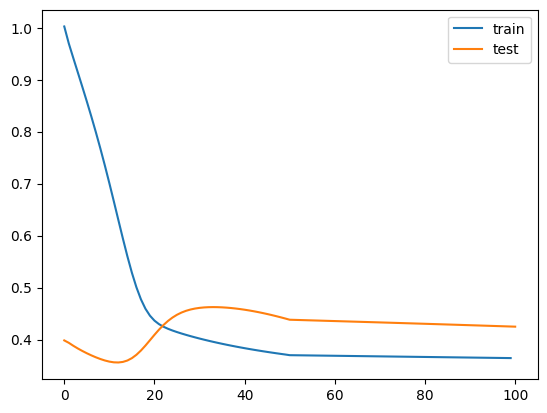

In [713]:
plt.plot(train_loss, label = "train")
plt.plot(test_loss, label = "test")
plt.legend()
plt.show()

In [714]:
def predict(data_loader, model):

    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)
    
    return output


train_eval_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

ystar_col = "Model forecast"
df_train[ystar_col] = predict(train_eval_loader, model).numpy()
df_test[ystar_col] = predict(test_loader, model).numpy()

df_out = pd.concat((df_train, df_test))[[target, ystar_col]]

for c in df_out.columns:
    df_out[c] = df_out[c] * target_stdev + target_mean

print(df_out)

     target_lead1  Model forecast
0           247.0     1260.078125
1           160.0      421.564453
2           288.0     2299.474609
3           188.0      668.919922
4           159.0     2275.382812
..            ...             ...
724       28259.0    44770.125000
725       37386.0    44905.000000
726       23519.0    44359.136719
727       20311.0    46886.726562
728       25664.0    49077.210938

[730 rows x 2 columns]


In [715]:
fig = px.line(df_out, labels=dict(created_at="Date", value="货量"))
fig.add_vline(x=test_start, line_width=4, line_dash="dash")
fig.update_layout(
    template=plot_template, legend=dict(orientation='h', y=1.02, title_text="")
)
fig.show()

In [629]:
route1_value = route1.values
input_x = route1_value[-5:,:]
input_x_dep = np.flip(input_x, 1)
input_x = input_x.reshape((1,5,2))
input_x_dep = input_x_dep.reshape((1,5,2))
print(input_x)
print(input_x_dep)
#1-1 ~ 1-31
prediction = []
# for i in range(31):
#   x_tensor = torch.tensor(input_x)
#   x_dep_tensor = torch.tensor(input_x_dep)
#   y_predict = model(x_tensor.float())
#   prediction.append(y_predict)
#   y_predict_dep = model(x_dep_tensor.float())
#   for i in range(5):
#     if not i == 4:
#       input_x[0,i,:] = input_x[0,i+1,:]
#     if i == 4:
#       input_x[0,i,:] = np.array([y_predict, y_predict_dep])
#   for i in range(5):
#     if not i == 4:
#       input_x[0,i,:] = input_x[0,i+1,:]
#     if i == 4:
#       input_x[0,i,:] = np.array([y_predict_dep, y_predict])


[[[28259. 15492.]
  [37386.  8230.]
  [23519. 29021.]
  [20311.  9991.]
  [25664. 13254.]]]
[[[15492. 28259.]
  [ 8230. 37386.]
  [29021. 23519.]
  [ 9991. 20311.]
  [13254. 25664.]]]


In [543]:
route1_value.shape

(730, 7)

In [627]:
route1_value = route1.values
input_x = route1_value[-5:,:]
input_x = input_x.reshape((1,5,2))
print(input_x)

a = 1
b =2
for i in range(5):
  if not i == 4:
    input_x[0,i,:] = input_x[0,i+1,:]
  if i == 4:
    input_x[0,i,:] = np.array([a,b])

print(input_x)

[[[28259. 15492.]
  [37386.  8230.]
  [23519. 29021.]
  [20311.  9991.]
  [25664. 13254.]]]
[[[3.7386e+04 8.2300e+03]
  [2.3519e+04 2.9021e+04]
  [2.0311e+04 9.9910e+03]
  [2.5664e+04 1.3254e+04]
  [1.0000e+00 2.0000e+00]]]


In [573]:
temp2 = temp.reshape((1,5,7))
tensortemp = torch.tensor(temp2, dtype=torch.float64)
outtemp = model(tensortemp.float())
outtemp

tensor([0.4904], grad_fn=<ReshapeAliasBackward0>)

In [ ]:
# class Sequence(nn.Module):
#     def __init__(self):
#         super(Sequence, self).__init__()
#         self.lstm1 = nn.LSTMCell(1, 51)
#         self.lstm2 = nn.LSTMCell(51, 1)

#     def forward(self, input, future=0):
#         outputs = []
#         h_t = Variable(
#             torch.zeros(input.size(0), 51), requires_grad=False)
#         c_t = Variable(
#             torch.zeros(input.size(0), 51), requires_grad=False)
#         h_t2 = Variable(
#             torch.zeros(input.size(0), 1), requires_grad=False)
#         c_t2 = Variable(
#             torch.zeros(input.size(0), 1), requires_grad=False)

#         for i, input_t in enumerate(input.chunk(input.size(1), dim=1)):
#             h_t, c_t = self.lstm1(input_t, (h_t, c_t))
#             h_t2, c_t2 = self.lstm2(c_t, (h_t2, c_t2))
#             outputs += [c_t2]

#         for i in range(future):  # if we should predict the future
#             h_t, c_t = self.lstm1(c_t2, (h_t, c_t))
#             h_t2, c_t2 = self.lstm2(c_t, (h_t2, c_t2))
#             outputs += [c_t2]

#         outputs = torch.stack(outputs, 1).squeeze(2)
#         return outputs
    

In [ ]:
# # route2: DC20->DC35
# route2 = pd.merge(DC20_DC35, DC4_DC20, on='date', how='left')
# route2 = pd.merge(route2, DC10_DC35, on='date', how='left')
# route2 = route2[['date', 'value_x', 'value_y', 'value']]
# route2.rename(columns={"date":"date", "value_x":"value", "value_y":"toDC20", "value":"toDC35"}, inplace=True)
# route2['toDC20'].fillna(0, inplace = True)
# route2['toDC35'].fillna(0, inplace = True)
# route2

In [ ]:
#  #route3: DC25->DC62
# route3 = pd.merge(DC25_DC62, DC53_DC25, on='date', how='left')
# route3 = pd.merge(route3, DC8_DC62, on='date', how='left')
# route3 = route3[['date', 'value_x', 'value_y', 'value']]
# route3.rename(columns={"date":"date", "value_x":"value", "value_y":"toDC25", "value":"toDC62"}, inplace=True)
# route3['toDC25'].fillna(0, inplace = True)
# route3['toDC62'].fillna(0, inplace = True)
# route3

In [ ]:
# plt.plot(DC14_DC10['date'], DC14_DC10['value'], label = "DC14_DC10")
# plt.plot(DC20_DC35['date'], DC20_DC35['value'], label = "DC20_DC35")
# plt.plot(DC25_DC62['date'], DC25_DC62['value'], label = "DC25_DC62")
# plt.legend()
# plt.show()

In [ ]:
# #Define functin
# # convert series to supervised learning
# def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
# 	n_vars = 1 if type(data) is list else data.shape[1]
# 	df = data
# 	cols, names = list(), list()
# 	# input sequence (t-n, ... t-1)
# 	for i in range(n_in, 0, -1):
# 		cols.append(df.shift(i))
# 		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
# 	# forecast sequence (t, t+1, ... t+n)
# 	for i in range(0, n_out):
# 		cols.append(df.shift(-i))
# 		if i == 0:
# 			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
# 		else:
# 			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
# 	# put it all together
# 	agg = pd.concat(cols, axis=1)
# 	agg.columns = names
# 	# drop rows with NaN values
# 	if dropnan:
# 		agg.dropna(inplace=True)
# 	return agg

In [ ]:
# ## Focus on DC14->DC10
# modified_route1 = series_to_supervised(route1, 3, 1)
# # drop columns we don't want to predict
# modified_route1.drop(modified_route1.columns[[0,4,8,12,14,15]], axis=1, inplace=True)
# # modified_route1.rename(columns={"var2(t-3)":"value(t-3)", "var3(t-3)":"toA(t-3)", "var4(t-3)":"toB(t-3)", "var2(t-2)":"value(t-2)",
# # "var3(t-2)":""}, inplace=True)

In [ ]:
# modified_route1